# Problem Setting
Following the book, $X = A\beta + U$. But only $Y_i = \min(X_i, c_i)$ is observed.

In [1]:
import fun.EM.em as em

import numpy as np
from numpy.linalg import inv
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
def column_vec(x):
    shape = x.shape
    return x.reshape(np.max(shape), 1)

In [3]:
n = 50
A = []
for i in range(n):
    if i < int(n/2):
        A.append([10])
    else:
        A.append([10])
        

A = np.matrix(A)
beta = column_vec(np.array([2]))

sigma = 2
U = column_vec(np.random.normal(0, sigma, size = n))

In [4]:
X = A@beta + U

In [5]:
c = column_vec(np.concatenate((np.ones(int(n/2)) * 22, np.ones(n - int(n/2)) * 20)))

In [6]:
Y = np.minimum(X, c)

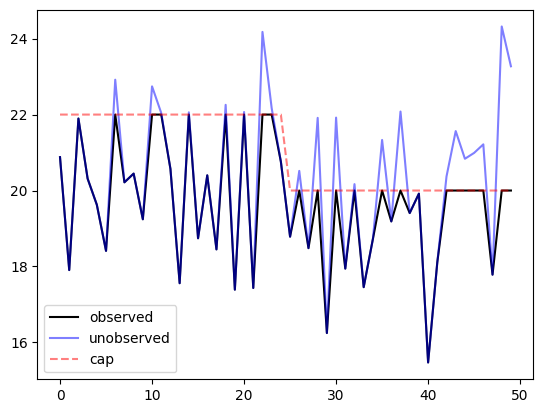

In [7]:
plt.plot(Y, color = 'black', label = "observed")
plt.plot(X, color = 'blue', alpha = 0.5, label = "unobserved")
plt.plot(c, color = 'red', alpha = 0.5, label = "cap", linestyle = "--")
plt.legend();

# Training the Model with Linear Regression

In [8]:
beta_lr = inv(A.T@A)@A.T@Y
print("Trained", np.round(beta_lr.T, 2))
print("True", beta.T)

Trained [[1.97]]
True [[2]]


In [9]:
pred_lr = A@beta_lr


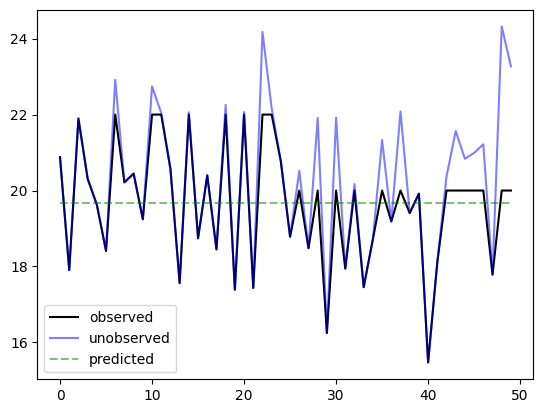

In [10]:
plt.plot(Y, color = 'black', label = "observed")
plt.plot(X, color = 'blue', alpha = 0.5, label = "unobserved")
plt.plot(pred_lr, color = 'green', alpha = 0.5, label = "predicted", linestyle = "--")
plt.legend();

# Train with Missing Data Model

In [11]:
def get_H(v):
    a =  norm.pdf(v) / (1 - norm.cdf(v))
    a[a > 5] = 5
    return a

def get_Hn(c, A, beta_n, sigma_n):
    return get_H((c - A@beta_n)/sigma_n)

def get_Dn(c, A, beta_n, sigma_n):
    
    # Pre-calculate
    r = c.shape[0]
    temp = A@beta_n
    
    # Split by term
    t1 = temp.T@temp
    t2 = r * sigma_n**2
    t3 = sigma_n * (c + temp ).T @ get_Hn(c, A, beta_n, sigma_n)
    # print(t1, t2, t3)
    
    
    
    return (t1 + t2 + t3)[0,0]
    

In [12]:
beta0 = beta_lr
sigma0 = np.std(np.diff(Y, axis = 0))
theta0 = np.array(np.append(beta0, [[sigma0]], axis = 0)).squeeze()
print(f"beta0: \n{beta0}")
print(f"sigma0: \n{sigma0}")

beta0: 
[[1.96750588]]
sigma0: 
2.4706721739494992


In [13]:
def update_em(data, theta):
    # Reading data
    y, c, A = data
    m = A.shape[1]
    
    # Load paramter
    beta_n, sigma_n = column_vec(theta[:m]), theta[m]
    Hn =  get_Hn(c, A, beta_n, sigma_n)
    
    # EM Update
    beta_np1 = inv(A.T@A)@A.T@(A@beta_n + sigma_n * Hn)
    
    # print(np.max(A@beta_n))
    
    # Compute
    Dn = get_Dn(c, A, beta_n, sigma_n)
    r = Y.shape[0]
    sigma_np1 = 1/r * (Dn - 2* (A@beta_np1).T @(A@beta_n + sigma_n * Hn)
                       + (A@beta_np1).T @ (A@beta_np1))
    # return beta_np1, sigma_np1[0,0]

    return column_vec(np.array(np.append(beta_np1, sigma_np1, axis = 0))).squeeze()

In [14]:
data = (Y, c, A)
theta0 = np.array(np.append(beta0, [[sigma0]], axis = 0))

In [15]:
model = em.EM()
model.load(data, update_em)
a = model.fit(theta0)

Max Iter Reached


/var/folders/b_/ps8r7v4s6fbbssck5mf0m9w40000gn/T/ipykernel_22774/2907590269.py:17: RuntimeWarning: overflow encountered in double_scalars
  t2 = r * sigma_n**2
/var/folders/b_/ps8r7v4s6fbbssck5mf0m9w40000gn/T/ipykernel_22774/2095958409.py:18: RuntimeWarning: overflow encountered in matmul
  sigma_np1 = 1/r * (Dn - 2* (A@beta_np1).T @(A@beta_n + sigma_n * Hn)
/var/folders/b_/ps8r7v4s6fbbssck5mf0m9w40000gn/T/ipykernel_22774/2095958409.py:18: RuntimeWarning: invalid value encountered in subtract
  sigma_np1 = 1/r * (Dn - 2* (A@beta_np1).T @(A@beta_n + sigma_n * Hn)
/var/folders/b_/ps8r7v4s6fbbssck5mf0m9w40000gn/T/ipykernel_22774/2095958409.py:19: RuntimeWarning: overflow encountered in matmul
  + (A@beta_np1).T @ (A@beta_np1))
/var/folders/b_/ps8r7v4s6fbbssck5mf0m9w40000gn/T/ipykernel_22774/2907590269.py:16: RuntimeWarning: overflow encountered in matmul
  t1 = temp.T@temp


In [16]:
theta1 = update_em(data, theta0)
print(theta1)
for i in range(20):
    theta1 = update_em(data, theta1)
    print(theta1)

[2.2592373 2.1933565]
[2.35348465 2.87050205]
[2.45413654 5.0796536 ]
[ 2.66684851 14.20378261]
[ 3.46655941 93.00281931]
[  10.0397094  3431.23767652]
[2.78778401e+02 4.33797345e+06]
[3.46222863e+05 6.84071119e+12]
[5.45809910e+11 1.70045027e+25]
[1.35676302e+24 1.05072523e+50]
[8.38357442e+48 4.01180317e+99]
[3.20095581e+098 5.84844658e+198]
[4.66638523e+197             nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]
[nan nan]


/var/folders/b_/ps8r7v4s6fbbssck5mf0m9w40000gn/T/ipykernel_22774/2907590269.py:17: RuntimeWarning: overflow encountered in double_scalars
  t2 = r * sigma_n**2
/var/folders/b_/ps8r7v4s6fbbssck5mf0m9w40000gn/T/ipykernel_22774/2095958409.py:18: RuntimeWarning: overflow encountered in matmul
  sigma_np1 = 1/r * (Dn - 2* (A@beta_np1).T @(A@beta_n + sigma_n * Hn)
/var/folders/b_/ps8r7v4s6fbbssck5mf0m9w40000gn/T/ipykernel_22774/2095958409.py:18: RuntimeWarning: invalid value encountered in subtract
  sigma_np1 = 1/r * (Dn - 2* (A@beta_np1).T @(A@beta_n + sigma_n * Hn)
/var/folders/b_/ps8r7v4s6fbbssck5mf0m9w40000gn/T/ipykernel_22774/2095958409.py:19: RuntimeWarning: overflow encountered in matmul
  + (A@beta_np1).T @ (A@beta_np1))
/var/folders/b_/ps8r7v4s6fbbssck5mf0m9w40000gn/T/ipykernel_22774/2907590269.py:16: RuntimeWarning: overflow encountered in matmul
  t1 = temp.T@temp
